In [1]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
green_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\green'
yellow_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\yellow'
abnormal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\abnormal'

In [3]:
green_set = datasets.ImageFolder(
    green_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

yellow_set = datasets.ImageFolder(
    yellow_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

abnormal_set = datasets.ImageFolder(
    abnormal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

green_train, green_test = torch.utils.data.random_split(green_set, [250, 50])  
yellow_train, yellow_test = torch.utils.data.random_split(yellow_set, [250, 50])  

normal_set = green_set + yellow_set
train_dataset1 = list(green_train)[:int(len(green_train)*0.2)] + list(yellow_train)[:int(len(yellow_train)*0.8)]
train_dataset2 = list(green_train)[:int(len(green_train)*0.2)] + list(yellow_train)[:int(len(yellow_train)*0.8)]
test_dataset = green_test + yellow_test

In [4]:
def make_dir(args):    
    import os

    MODEL_DIR = f"FL_model/client = {args.num_clients}"
    try:
        os.makedirs(MODEL_DIR)
    except FileExistsError:
        print('Directories not created because they already exist')

In [5]:
def list_np_tensor(param_data):
    data = []
    for i in range(np.size(param_data, 0)):
        data.append(np.concatenate((param_data[i]['net.0.weight'].cpu().numpy(), np.expand_dims(param_data[i]['net.0.bias'].cpu().numpy(), axis=1)),axis=1))
    
    data = torch.Tensor(data)
    return data
    
def save_param(param_data):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    dtf = pd.DataFrame(dt)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def save_param_with_round(param_data, round_list, args):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    
    round_tensor = torch.tensor(round_list).view(-1, 1)
    dt_r = torch.cat((dt, round_tensor), dim=1)
    
    dtf = pd.DataFrame(dt_r)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def load_data(args):    
    ldt = pd.read_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    ldt = ldt.values
    ldt = np.delete(ldt, 0, 1)
    return ldt

def data_split(args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

In [6]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)      
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        
        return output

In [7]:
def define_client(partition, r, num, args):
    train_loader = DataLoader(partition[f'train{num+1}'], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = ConvAutoEncoder().to(device)
    else:
        net = torch.load(args.INIT_PATH)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

In [8]:
def train(net, train_loader, criterion, optimizer, args):
    
    train_loss = 0
    for epoch in range(args.num_epochs):        
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
    train_loss /= len(train_loader)*args.num_epochs

    torch.save(net, args.NET_PATH)
    return net, train_loss

In [9]:
def Fed_AVG(model, client_model_list, args):
    model.train()
    local_weights = []

    for i in range(args.num_clients):
        local_weights.append(copy.deepcopy(client_model_list[i].state_dict()))
    w_avg = copy.deepcopy(local_weights[0]) #type of w_avg : <class 'collections.OrderedDict'>

    for key in w_avg.keys():
        for i in range(1,len(local_weights)):
            w_avg[key] += local_weights[i][key]
        w_avg[key] = torch.div(w_avg[key], len(local_weights))

    global_weights = w_avg
    model.load_state_dict(global_weights)
    torch.save(model, args.INIT_PATH)

    return model, local_weights

In [10]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition[f'test'], batch_size=args.batch_size, shuffle=True)
    model.eval()

    loss = 0
    round_loss = 0
            
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)
        loss += criterion(outputs, images).item()
    
    round_loss = loss / len(test_loader)
 
    return round_loss

In [11]:
def experiment(partition, args):
    model = ConvAutoEncoder().to(device)
    torch.save(model, args.INIT_PATH)

    round_losses = []
    round_client_losses = []
    param_data = []
    round_list = []

    for r in range(args.num_rounds):
        train_losses = []
        client_model_list = []
        
        for num in range(args.num_clients):
            setattr(args, 'NET_PATH', f'FL_model/client = {args.num_clients}/client_{num}.pth')
            
            net, train_loader, criterion, optimizer = define_client(partition, r, num, args)
            net, train_loss = train(net, train_loader, criterion, optimizer, args)
            
            client_model_list.append(net)
            train_losses.append(train_loss)
            
        model, local_weights = Fed_AVG(model, client_model_list, args)
        round_loss = test(model, partition, criterion, args)

        if r%10==0 or r==args.num_rounds-1:
            print(f'[Round {r}] Round Loss: {round_loss:.5f} Client1 Loss: {train_losses[0]:.5f} Client2 Loss: {train_losses[1]:.5f}')

        round_losses.append(round_loss)
        round_client_losses.append(train_losses)
        round_list.append([r, r, r])
        param_data += local_weights
        
    return round_losses, round_client_losses, round_list, param_data

In [12]:
def plot_loss(round_loss, round_client_losses):
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
    ax = plt.subplot(1,1,1)
    ax.plot(round_loss, label='Avg')
    ax.plot(np.array(round_client_losses)[:,0], label='Client1')
    ax.plot(np.array(round_client_losses)[:,1], label='Client2')
    ax.grid()
    ax.legend()

    axins = inset_axes(ax, 1.0, 0.8, loc = 1, bbox_to_anchor=(0.6, 0.75), bbox_transform = ax.figure.transFigure)
    
    axins.plot(round_loss, label = 'Avg')
    axins.plot(np.array(round_client_losses)[:,0], label = 'Client1')
    axins.plot(np.array(round_client_losses)[:,1], label = 'Client2')
    axins.set_xlim(-0.5, 5)
    axins.set_ylim(0.04,0.06)
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec = "0.4")

    plt.show()

Directories not created because they already exist
[Round 0] Round Loss: 0.05358 Client1 Loss: 0.05506 Client2 Loss: 0.04922
[Round 10] Round Loss: 0.02057 Client1 Loss: 0.02029 Client2 Loss: 0.02028
[Round 20] Round Loss: 0.01410 Client1 Loss: 0.01284 Client2 Loss: 0.01284
[Round 30] Round Loss: 0.01061 Client1 Loss: 0.00901 Client2 Loss: 0.00904
[Round 40] Round Loss: 0.00730 Client1 Loss: 0.00577 Client2 Loss: 0.00578
[Round 50] Round Loss: 0.00429 Client1 Loss: 0.00337 Client2 Loss: 0.00334
[Round 60] Round Loss: 0.00260 Client1 Loss: 0.00212 Client2 Loss: 0.00211
[Round 70] Round Loss: 0.00216 Client1 Loss: 0.00184 Client2 Loss: 0.00183
[Round 80] Round Loss: 0.00203 Client1 Loss: 0.00172 Client2 Loss: 0.00172
[Round 90] Round Loss: 0.00193 Client1 Loss: 0.00167 Client2 Loss: 0.00167
[Round 100] Round Loss: 0.00189 Client1 Loss: 0.00162 Client2 Loss: 0.00162
[Round 110] Round Loss: 0.00184 Client1 Loss: 0.00158 Client2 Loss: 0.00158
[Round 120] Round Loss: 0.00177 Client1 Loss: 0.

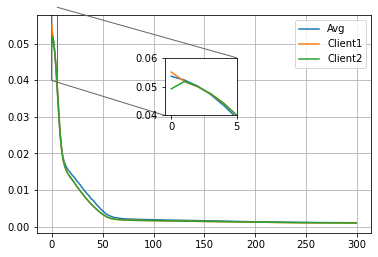

In [19]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.num_epochs = 5
args.num_rounds = 300
args.num_clients = 2
args.lr = 0.00001

args.batch_size = 8

make_dir(args)

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'


partition = {'train1':train_dataset1, 'train2':train_dataset2, 'test':test_dataset}
    
round_loss, round_client_losses, round_list, param_data = experiment(partition, args)
plot_loss(round_loss, round_client_losses)

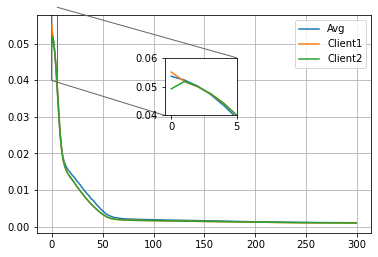

In [20]:
plot_loss(round_loss, round_client_losses)

In [21]:
model = ConvAutoEncoder()
model = torch.load(args.INIT_PATH)
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')

Normal loss: 0.0010623223171569408
Abnormal loss: 0.0017894931754033844


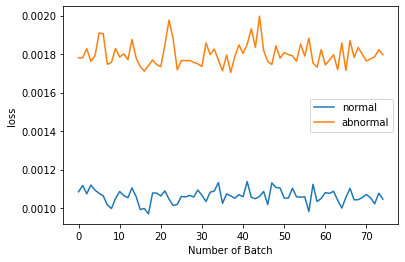

In [22]:
plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

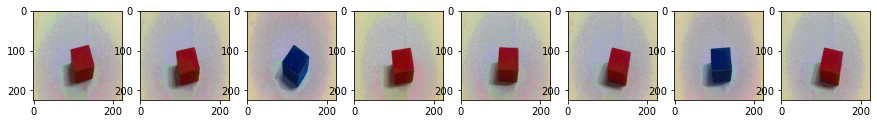

0.0017256324645131826
0.0017459465889260173
0.0022644412238150835
0.0017954185605049133
0.0017594974488019943
0.0017340678023174405
0.0019816437270492315
0.0017389490967616439


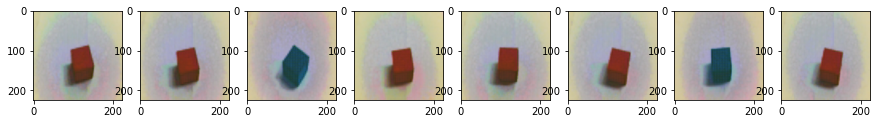

In [23]:
abnormal_images, abnormal_labels = next(iter(abnormal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()



model.cpu()
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

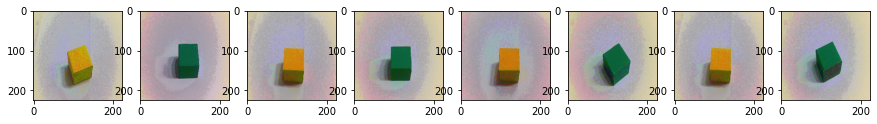

c:\Users\WorkStation\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([8, 3, 224, 224])) that is different to the input size (torch.Size([3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.01161320973187685
0.013325882144272327
0.011585693806409836
0.01137573178857565
0.012726310640573502
0.011724701151251793
0.011557801626622677
0.012355485931038857


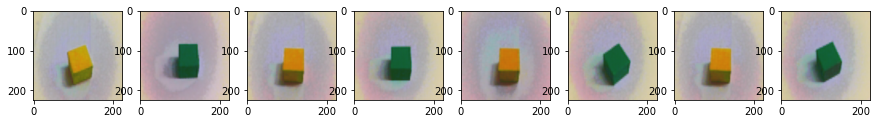

In [24]:
normal_images, normal_labels = next(iter(normal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), normal_images, normal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()


model.cpu()
normal_output = model(normal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), normal_output, normal_labels):
    loss = criterion(img, normal_images)
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()